# MIMO Broadcast Channel

In [1]:
import numpy as np
from numpy import sqrt, pi
import scipy as sp
from scipy import special
import tensorflow as tf
import time
import datetime
from keras.layers.normalization import BatchNormalization
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import unitary_group
from scipy.stats import ortho_group

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.2.0
Num GPUs Available:  1


In [9]:
# (n,k) = 2^k messages over n complex-valued channel uses
k = 2
n = 1 # complex-valued dimensions
R = k/n # bits / 2 dims

M = 2**k # constellation size
N = 2*n # real-valued dimensions

Tx = 2 # number of transmit antennas
Rx = 2 # number of receivers/users

Mt = M**Rx # total message set of the transmitter

Tx_NN = 512 # neurons in hidden layer at transmitter
Rx_NN = 256 # neurons in hidden layer at receiver
batch_norm = False

enc_dims = [M**Rx+2*Tx*Rx, Tx_NN,Tx_NN,Tx_NN, N*Tx]
dec_dims = [N+2*Tx, Rx_NN,Rx_NN,Rx_NN, M]

B = 10240 # minibatch size; should be a multiple of Mt
lr = 0.001 # learning rate

EsNo_dB_set = np.array([12,15,18,20])

In [4]:
def normalization(x): # power per tx antenna is 1
    """ x has shape [B, Tx*N]
    """
    Bt = x.shape[0] # assumed to be a multiple of Mt
    x = tf.reshape(x, [Bt//Mt, Mt, Tx*N])
    x = x / tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(x), axis=2, keepdims=True), axis=1, keepdims=True)/(Tx*n))
    return tf.reshape(x, [Bt, Tx*N])

def mimo_channel(xr, xi, Hr, Hi, sigma2):
    """ xr,xi have shape [B, Tx, n]
        Hr,Hi have shape [B, Rx, Tx]
        yr,yi have shape [B, Rx, n]
        y = H*x + n
    """
    yr = tf.matmul(Hr,xr) - tf.matmul(Hi,xi)
    yi = tf.matmul(Hr,xi) + tf.matmul(Hi,xr)
    yr = yr + tf.sqrt(sigma2)*tf.random.normal(tf.shape(yr))
    yi = yi + tf.sqrt(sigma2)*tf.random.normal(tf.shape(yi))
    return yr, yi

class Encoder(tf.Module):
    def __init__(self, dims, batch_norm=False):
        super().__init__()
        if len(dims) < 2: raise ValueError("Input list has to be at least length 2")
        
        self.layers = []
        for i in range(len(dims)-2):
            if batch_norm == True:
                self.layers.append(tf.keras.layers.BatchNormalization())
            self.layers.append(tf.keras.layers.Dense(dims[i+1], activation="relu"))
        if batch_norm == True:
            self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Dense(dims[-1], activation=None))
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return normalization(x)
        
class Decoder(tf.Module):
    def __init__(self, dims, batch_norm=False):
        super().__init__()
        if len(dims) < 2: raise ValueError("Input list has to be at least length 2")
        
        self.layers = []
        for i in range(len(dims)-2):
            if batch_norm == True:
                self.layers.append(tf.keras.layers.BatchNormalization())
            self.layers.append(tf.keras.layers.Dense(dims[i+1], activation="relu"))
        if batch_norm == True:
            self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Dense(dims[-1], activation="softmax"))
        
    def __call__(self, x, training):
        for layer in self.layers:
            if "batch_normalization" in layer.name:
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x

class AE(tf.Module):
    """ AE: communications autoencoder
    
    Args:
        enc_dims: dimensions (neurons per layer) for encoder
        dec_dims: dimensions (neurons per layer) for decoder
    
    """
    def __init__(self, enc_dims, dec_dims, batch_norm=False):
        super().__init__()
        self.Encoder = Encoder(enc_dims, batch_norm)
        self.Decoder1 = Decoder(dec_dims, batch_norm)
        #self.Decoder2 = Decoder(dec_dims, batch_norm)
        self.Decoder2 = self.Decoder1
    
    def __call__(self, ohv, Hr, Hi, sigma2, training=False):
        Hr = tf.repeat(Hr, Mt, axis=0)
        Hi = tf.repeat(Hi, Mt, axis=0)
        HrR = tf.reshape(Hr, [-1, Tx*Rx])
        HiR = tf.reshape(Hi, [-1, Tx*Rx])
        
        x = self.Encoder(tf.concat([ohv, HrR, HiR], axis=1))
        
        xr = tf.reshape(x[:,0:N*Tx//2], [-1, Tx, N//2])
        xi = tf.reshape(x[:,N*Tx//2:N*Tx], [-1, Tx, N//2])
    
        yr, yi = mimo_channel(xr, xi, Hr, Hi, sigma2)
        
        # local observation and CSI
        y1 = tf.concat([yr[:,0,:], yi[:,0,:]], axis=1)
        y2 = tf.concat([yr[:,1,:], yi[:,1,:]], axis=1)
        
        #yr = tf.reshape(yr, [-1, Rx*N//2])
        #yi = tf.reshape(yi, [-1, Rx*N//2])
        #y = tf.concat([yr, yi], axis=1)
        
        qxy1 = self.Decoder1(tf.concat([y1, Hr[:,0,:], Hi[:,0,:]], axis=1), training)
        qxy2 = self.Decoder2(tf.concat([y2, Hr[:,1,:], Hi[:,1,:]], axis=1), training)
        
        return qxy1, qxy2

# Training Routine (Eager)

In [13]:
@tf.function # debug in eager mode, then compile into a static graph (faster)
def train_step_eager(sigma2_set):
    indices1 = tf.tile(tf.repeat(tf.range(M), M), [B//Mt])
    indices2 = tf.tile(tf.range(M), [B//M])
    ohv1 = tf.one_hot(indices1, depth=M)
    ohv2 = tf.one_hot(indices2, depth=M)
    
    tx_indices = M*indices1+indices2
    tx_ohv = tf.one_hot(tx_indices, depth=Mt)
    
    Hr = tf.random.normal([B//Mt, Rx, Tx])/np.sqrt(2)
    Hi = tf.random.normal([B//Mt, Rx, Tx])/np.sqrt(2)
    
    if True:
        sigma2 = sigma2_set
    else: # generate random sigma2 
        sigma_ind = tf.random.uniform(shape=(B,1,1), minval=0, maxval=len(sigma2_set), dtype=tf.dtypes.int32)
        sigma2 = tf.gather(sigma2_set, sigma_ind)
    
    with tf.GradientTape() as tape:
        qxy1, qxy2 = model(tx_ohv, Hr, Hi, sigma2, training=True)
        epsilon = 1e-6 # to avoid log(0) = -Inf
        L1 = -M*tf.reduce_mean(ohv1*tf.math.log(qxy1+epsilon)/np.log(2))
        L2 = -M*tf.reduce_mean(ohv2*tf.math.log(qxy2+epsilon)/np.log(2))
        L = (L1+L2)/2
        
    grads = tape.gradient(L, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))    
    return L

In [14]:
iterations = 100000
print_interval = 1000

log_dir = "logs/3_mimo_broadcast/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary_writer = tf.summary.create_file_writer(log_dir)

model = AE(enc_dims, dec_dims, batch_norm)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

loss_sv = []
total_iter = 0 
for EsNo_dB_set_this in EsNo_dB_set:
    print("EsNo = {:.1f} dB".format(EsNo_dB_set_this), flush=True)

    EsNo_r_set = 10**(EsNo_dB_set_this/10)
    sigma2_set = 1/(2*EsNo_r_set) # noise power per real dimension
    sigma2_set = tf.convert_to_tensor(sigma2_set, dtype=tf.float32)

    t = tqdm(range(1, iterations+1), desc="loss")
    for i in t:
        L = train_step_eager(sigma2_set)
        total_iter = total_iter + 1

        if i%print_interval==0 or i==1:
            with train_summary_writer.as_default():
                tf.summary.scalar('loss', L, step=total_iter)

            t.set_description("loss={:.5f}".format(L))
            t.refresh() # to show immediately the update
            loss_sv.append(L)

EsNo = 12.0 dB


loss=0.09043:  80%|████████  | 80490/100000 [12:33<03:07, 104.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss=0.02056:  35%|███▍      | 34943/100000 [05:26<10:04, 107.68it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss=0.01848:  87%|████████▋ | 86598/100000 [13:27<02:02, 109.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change th

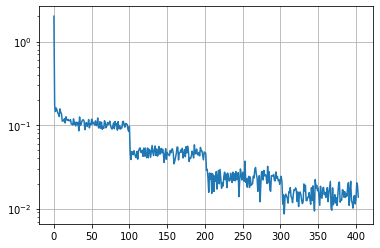

In [15]:
plt.semilogy(loss_sv)
plt.grid()

# Symbol/Block Error Rate

In [16]:
@tf.function
def get_SER(L, sigma2):
    m1 = tf.tile(tf.repeat(tf.range(M), M), [L//Mt])
    m2 = tf.tile(tf.range(M), [L//M])
    ohv1 = tf.one_hot(m1, depth=M)
    ohv2 = tf.one_hot(m2, depth=M)
    
    tx_m = M*m1+m2
    tx_ohv = tf.one_hot(tx_m, depth=Mt)
    
    #s = tf.tile(tf.range(M, dtype=tf.dtypes.int64), [L//M])
    #ohv = tf.one_hot(s, depth=M)
    
    Hr = tf.random.normal([L//Mt, Rx, Tx])/np.sqrt(2) 
    Hi = tf.random.normal([L//Mt, Rx, Tx])/np.sqrt(2) 
    
    qxy1, qxy2 = model(tx_ohv, Hr, Hi, sigma2)
    mhat1 = tf.math.argmax(qxy1, axis=1, output_type=tf.dtypes.int32)
    mhat2 = tf.math.argmax(qxy2, axis=1, output_type=tf.dtypes.int32)
    
    err_vec1 = tf.cast(m1 != mhat1, dtype=tf.dtypes.int32)
    err_vec2 = tf.cast(m2 != mhat2, dtype=tf.dtypes.int32)
    
    return tf.reduce_sum(err_vec1), tf.reduce_sum(err_vec2)

In [17]:
minErr = 10000 # 50k = 8h
maxSym = minErr/1e-5
L = B # blocks 

SNR_dB = np.arange(0, 35, 1)
SNR_r = 10**(SNR_dB/10)

SNRlen = len(SNR_dB)
SymErrs = np.zeros([2, SNRlen])
Syms = np.zeros([SNRlen])

t = tqdm(range(SNRlen), desc="SNR=")
for II in t:
    #print("SNR = {} dB".format(SNR_dB[II]))
    t.set_description("SNR={:.1f}".format(SNR_dB[II]))
    t.refresh() # to show immediately the update
    totErr1, totErr2, totSym = 0, 0, 0
    sigma2 = tf.convert_to_tensor(1/(2*SNR_r[II]), dtype=tf.float32)

    while ((totErr1+totErr2 < minErr) and (totSym <= maxSym)):
        thisErr1, thisErr2 = get_SER(L,sigma2)
        totErr1 = totErr1 + np.asarray([thisErr1.numpy()])
        totErr2 = totErr2 + np.asarray([thisErr2.numpy()])
        totSym = totSym + L
    
    #print(totErr)
    SymErrs[0,II] = totErr1
    SymErrs[1,II] = totErr2
    Syms[II] = totSym

print(SymErrs)
SER = SymErrs/Syms
print(SER)

SNR=34.0: 100%|██████████| 35/35 [00:24<00:00,  1.45it/s]

[[9895. 9354. 8641. 7766. 6889. 6151. 5039. 6485. 5166. 5437. 5043. 5026.
  5104. 5003. 5164. 4957. 5082. 5132. 4983. 4969. 4959. 5077. 5055. 5001.
  5150. 5051. 5051. 5039. 5053. 5012. 5038. 5116. 4997. 5115. 5123.]
 [9953. 9375. 8723. 7892. 6932. 6095. 5043. 6626. 5302. 5356. 5091. 5123.
  5124. 5112. 5254. 5146. 5138. 5047. 5060. 5060. 5043. 4942. 5020. 5024.
  4869. 4953. 4962. 4985. 4976. 5013. 4974. 4886. 5016. 4895. 4896.]]
[[0.4831543  0.45673828 0.42192383 0.37919922 0.33637695 0.3003418
  0.24604492 0.21110026 0.16816406 0.13273926 0.09849609 0.07011719
  0.04984375 0.03257161 0.02292259 0.01512756 0.01033936 0.00759351
  0.00559335 0.00411232 0.00343459 0.00291648 0.00239637 0.00208709
  0.00194181 0.00174916 0.00159117 0.00153299 0.00147301 0.0014187
  0.00134058 0.00132522 0.00127412 0.00123032 0.00127952]
 [0.48598633 0.45776367 0.42592773 0.38535156 0.33847656 0.29760742
  0.24624023 0.2156901  0.17259115 0.13076172 0.09943359 0.07147042
  0.05003906 0.03328125 0.0233220

In [18]:
from io import StringIO

tmpstr = StringIO("""
-3.010299956639812 0.489701850000000
0.989700043360188 0.354083335000000
4.989700043360187 0.209233895000000
8.989700043360187 0.102096600000000
12.989700043360187 0.043928530000000
16.989700043360187 0.017997210000000
20.989700043360187 0.007111665000000
24.989700043360187 0.002877250000000
28.989700043360187 0.001153770000000
32.989700043360187 0.000422052602069
36.989700043360187 0.000183830039609
""")

ZF = np.genfromtxt(tmpstr, delimiter=' ')

tmpstr = StringIO("""
-3.010299956639812 0.413666870000000
0.989700043360188 0.275328650000000
4.989700043360187 0.138032940000000
8.989700043360187 0.042139330000000
12.989700043360187 0.008555370000000
16.989700043360187 0.001498875000000
20.989700043360187 0.000202392201599
24.989700043360187 0.000031515591412
""")

VP = np.genfromtxt(tmpstr, delimiter=' ')

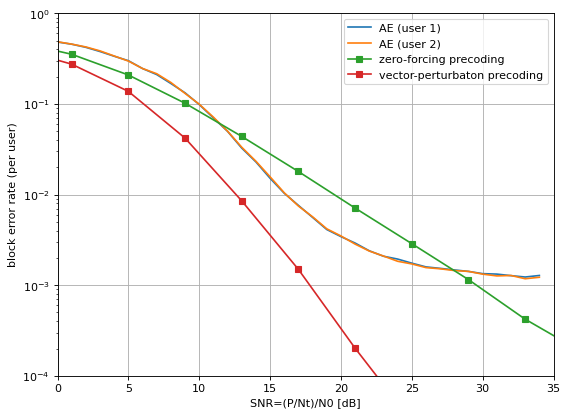

In [19]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

#plt.semilogy(SNR_dB-10*np.log10(2), SER, label='Autoencoder')
plt.semilogy(SNR_dB, SER[0,:], label='AE (user 1)')
plt.semilogy(SNR_dB, SER[1,:], label='AE (user 2)')

plt.semilogy(ZF[:,0], ZF[:,1], marker='s', linestyle='solid', label='zero-forcing precoding')
plt.semilogy(VP[:,0], VP[:,1], marker='s', linestyle='solid', label='vector-perturbaton precoding')
plt.xlabel('SNR=(P/Nt)/N0 [dB]')
plt.ylabel('block error rate (per user)')
plt.ylim(1e-4, 1)
plt.xlim(0, 35)
plt.legend()
plt.grid()
plt.show()